In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd
import datetime as dt

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from scipy import stats

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Solar_Power"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
#import data
plant_1_gen = pd.read_csv("Plant_1_Generation_data.csv")
plant_2_gen = pd.read_csv("Plant_2_Generation_data.csv")
plant_1_wea = pd.read_csv("Plant_1_Weather_Sensor_data.csv")
plant_2_wea = pd.read_csv("Plant_2_Weather_Sensor_data.csv")


## Data Exploration
our dataset consist of 4 files 2 for each plant
- power generation data
- weather sensor data

### The power generations data consists of 7 fields:
| DATE_TIME | PLANT_ID | SOURCE_KEY | DC_POWER | AC_POWER | DAILY_YIELD | TOTAL_YIELD |
| --------- | -------- | ---------- | -------- | -------- | ----------- | ----------- |
| Date and time for each observation (%d-%m-%Y %H:%M). Observations recorded at 15 minute intervals. | Plant ID - this will be common for the entire file. | Source key in this file stands for the inverter id. | Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. | Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. | Daily yield is a cumulative sum of power generated on that day till that point in time. | This is the total yield for the inverter till that point in time. |

### The weather data consists of 6 fields:
| DATE_TIME | PLANT_ID | SOURCE_KEY | AMBIENT_TEMPERATURE | MODULE_TEMPERATURE | IRRADIATION |
| --------- | -------- | ---------- | -------- | -------- | ----------- |
| Date and time for each observation (%d-%m-%Y %H:%M). Observations recorded at 15 minute intervals. | Plant ID - this will be common for the entire file. | Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant. | This is the ambient temperature at the plant. | There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module. | Amount of irradiation for the 15 minute interval. Solar irradiation is the quantity that measures the energy per unit area of ​​incident solar radiation on a surface - the power received during a time (J/m2 or Wh/m2 )  |

Data is gathered every 15 minutes for 34 days.

Expecting 3264 samples per sampling point:

24 hours x 4 times per hour x 34 days = 3264 samples

## check columns for missing values
### plant 1

In [10]:
plant1_info = plant_1_gen.isnull().sum()
print(plant1_info)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


In [12]:
plant1_wea = plant_1_wea.isnull().sum()
print(plant1_wea)

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


### Plant 2

In [21]:

plant2_info = plant_2_gen.isnull().sum()
print(plant2_info)

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64


In [22]:
plant2_wea = plant_2_wea.isnull().sum()
print(plant2_wea)

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64


In [20]:
#Unique values of inverter id
print(plant_1_gen['SOURCE_KEY'].nunique())
print(plant_2_gen['SOURCE_KEY'].nunique())

22
22


In [39]:
#Data for 34 days and continuous dates
pd.to_datetime(plant_1_gen['DATE_TIME']).dt.date.unique()

array([datetime.date(2020, 5, 15), datetime.date(2020, 5, 16),
       datetime.date(2020, 5, 17), datetime.date(2020, 5, 18),
       datetime.date(2020, 5, 19), datetime.date(2020, 5, 20),
       datetime.date(2020, 5, 21), datetime.date(2020, 5, 22),
       datetime.date(2020, 5, 23), datetime.date(2020, 5, 24),
       datetime.date(2020, 5, 25), datetime.date(2020, 5, 26),
       datetime.date(2020, 5, 27), datetime.date(2020, 5, 28),
       datetime.date(2020, 5, 29), datetime.date(2020, 5, 30),
       datetime.date(2020, 5, 31), datetime.date(2020, 1, 6),
       datetime.date(2020, 2, 6), datetime.date(2020, 3, 6),
       datetime.date(2020, 4, 6), datetime.date(2020, 5, 6),
       datetime.date(2020, 6, 6), datetime.date(2020, 7, 6),
       datetime.date(2020, 8, 6), datetime.date(2020, 9, 6),
       datetime.date(2020, 10, 6), datetime.date(2020, 11, 6),
       datetime.date(2020, 12, 6), datetime.date(2020, 6, 13),
       datetime.date(2020, 6, 14), datetime.date(2020, 6, 15),
 

In [40]:
#Inverterids
#Some inverters have more data points then the others
print("Plant 1 statistics \n", plant_1_gen.SOURCE_KEY.value_counts())
print("Plant 2 statistics \n", plant_2_gen.SOURCE_KEY.value_counts())

Plant 1 statistics 
 bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ih0vzX44oOqAx2f    3130
ZnxXDlPa8U1GXgE    3130
wCURE6d3bPkepu2    3126
z9Y9gH1T5YWrNuG    3126
iCRJl6heRkivqQ3    3125
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
zVJPv84UY57bAof    3124
rGa61gmuvPhdLxV    3124
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
ZoEaEvLYb1n2sOq    3123
adLQvlD726eNBSB    3119
zBIq5rxdHJRwDNY    3119
1IF53ai7Xc0U56Y    3119
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: SOURCE_KEY, dtype: int64
Plant 2 statistics 
 vOuJvMaM2sgwLmb    3259
PeE6FRyGXUgsRhN    3259
WcxssY2VbP4hApt    3259
LlT2YUhhzqhg5Sw    3259
xoJJ8DcxJEcupym    3259
LYwnQax7tkwH5Cb    3259
oZZkBaNadn6DNKz    3259
rrq4fwE8jgrTyWY    3259
9kRcWv60rDACzjR    3259
V94E5Ben1TlhnDV    3259
q49J1IKaHRwDQnt    3259
81aHJ1q11NBPMrL    3259
oZ35aAeoifZaQzV    3195
Mx2yZCDsyf6DPfv    3195
Et9kgGMDl729KT4    3195
4UPUqMRk7TRMgml    3195
Qf4GUc1pJu5T6c6

In [41]:
#Plant 1 weather data
plant_1_wea['DATE_TIME'] = pd.to_datetime(plant_1_wea['DATE_TIME']) 
plant_1_wea['TIME'] = plant_1_wea['DATE_TIME'].dt.time 
#convert datetime column to just date
plant_1_wea['DATE'] = pd.to_datetime(plant_1_wea['DATE_TIME'].dt.date)
print(plant_1_wea['DATE'])

#Plant 2 weather data
plant_2_wea['DATE_TIME'] = pd.to_datetime(plant_2_wea['DATE_TIME']) 
plant_2_wea['TIME'] = plant_2_wea['DATE_TIME'].dt.time 
#convert datetime column to just date
plant_2_wea['DATE'] = pd.to_datetime(plant_2_wea['DATE_TIME'].dt.date)


0      2020-05-15
1      2020-05-15
2      2020-05-15
3      2020-05-15
4      2020-05-15
5      2020-05-15
6      2020-05-15
7      2020-05-15
8      2020-05-15
9      2020-05-15
10     2020-05-15
11     2020-05-15
12     2020-05-15
13     2020-05-15
14     2020-05-15
15     2020-05-15
16     2020-05-15
17     2020-05-15
18     2020-05-15
19     2020-05-15
20     2020-05-15
21     2020-05-15
22     2020-05-15
23     2020-05-15
24     2020-05-15
25     2020-05-15
26     2020-05-15
27     2020-05-15
28     2020-05-15
29     2020-05-15
          ...    
3152   2020-06-17
3153   2020-06-17
3154   2020-06-17
3155   2020-06-17
3156   2020-06-17
3157   2020-06-17
3158   2020-06-17
3159   2020-06-17
3160   2020-06-17
3161   2020-06-17
3162   2020-06-17
3163   2020-06-17
3164   2020-06-17
3165   2020-06-17
3166   2020-06-17
3167   2020-06-17
3168   2020-06-17
3169   2020-06-17
3170   2020-06-17
3171   2020-06-17
3172   2020-06-17
3173   2020-06-17
3174   2020-06-17
3175   2020-06-17
3176   202

Analysis of weather dataset for both the plants:
Observations:
1. The mean solar irradiation values for both plants are similar.
2. The mean module temperature of Plant 1 is  lower than Plant 2 most of the time.
3. The mean ambient temperature of Plant 1 is much lower than Plant 2.


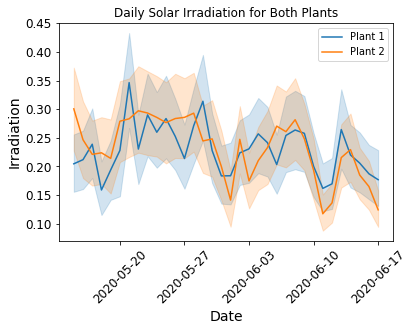

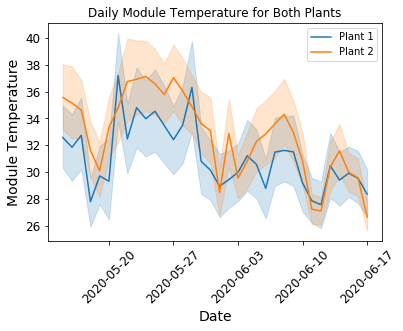

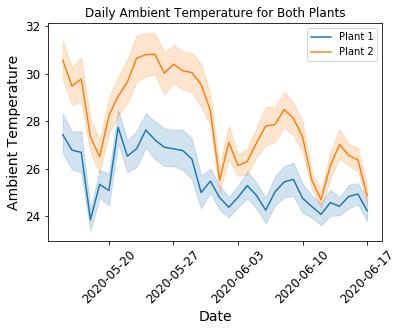

In [42]:
# Comparing both plants
# Daily Irradiation
ambient_compare = sns.lineplot(x='DATE', y='IRRADIATION', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='IRRADIATION', data=plant_2_wea, err_style='band', label='Plant 2', ax=ambient_compare)
plt.ylabel('Irradiation')
plt.xlabel('Date')
plt.title('Daily Solar Irradiation for Both Plants')
plt.xticks(rotation=45)
plt.show()

# Daily Module Temperature
modtemp_compare = sns.lineplot(x='DATE', y='MODULE_TEMPERATURE', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='MODULE_TEMPERATURE', data=plant_2_wea, err_style='band', label='Plant 2', ax=modtemp_compare)
plt.ylabel('Module Temperature')
plt.xlabel('Date')
plt.title('Daily Module Temperature for Both Plants')
plt.xticks(rotation=45)
plt.show()

# Daily Ambient Temperature
ambtemp_compare = sns.lineplot(x='DATE', y='AMBIENT_TEMPERATURE', data=plant_1_wea, err_style='band', label='Plant 1')
sns.lineplot(x='DATE', y='AMBIENT_TEMPERATURE', data=plant_2_wea, err_style='band', label='Plant 2', ax=ambtemp_compare)
plt.ylabel('Ambient Temperature')
plt.xlabel('Date')
plt.title('Daily Ambient Temperature for Both Plants')
plt.xticks(rotation=45)
plt.show()


In [43]:
# The mean of solar Irradiation for both plants are similar
mean_irradiationplant1 = plant_1_wea['IRRADIATION'].mean()
print('Mean of solar irradition from Plant1', mean_irradiationplant1)
mean_irradiationplant2 =  plant_2_wea['IRRADIATION'].mean()
print('Mean of solar irradition from Plant2', mean_irradiationplant2)

Mean of solar irradition from Plant1 0.22831283006565126
Mean of solar irradition from Plant2 0.23273697972872917


In [44]:
# The mean of Module Temperature for both plants (Plant 1 is lower then Plant 2)
mean_moduletempplant1 = plant_1_wea['MODULE_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant1', mean_moduletempplant1)
mean_moduletempplant2 =  plant_2_wea['MODULE_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant2', mean_moduletempplant2)

Mean of Module Temperature from Plant1 31.09101537842638
Mean of Module Temperature from Plant2 32.77240792902497


In [45]:
# The mean of Ambient Temperature for both plants (Plant 1 is lower then Plant 2)
mean_ambienttempplant1 = plant_1_wea['AMBIENT_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant1', mean_ambienttempplant1)
mean_ambienttempplant2 =  plant_2_wea['AMBIENT_TEMPERATURE'].mean()
print('Mean of Module Temperature from Plant2', mean_ambienttempplant2)

Mean of Module Temperature from Plant1 25.53160571756439
Mean of Module Temperature from Plant2 28.069399882321147


In [46]:
# drop unwanted columns. 
df_weather1 = plant_1_wea.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_plant1 = plant_1_gen.drop(['PLANT_ID'], axis=1)

In [47]:
#Formatedattime
df_plant1['DATE_TIME']= pd.to_datetime(df_plant1['DATE_TIME'],format='%d-%m-%Y %H:%M')
df_weather1['DATE_TIME']= pd.to_datetime(df_weather1['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
df_plant1.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,2020-05-15,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,2020-05-15,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,2020-05-15,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,2020-05-15,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [48]:
#Merge the dataset
df_plant_weather1 = df_plant1.merge(df_weather1, left_on='DATE_TIME', right_on='DATE_TIME')
df_plant_weather1.head()


,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME,DATE
0,2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
1,2020-05-15,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
2,2020-05-15,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
3,2020-05-15,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
4,2020-05-15,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0,00:00:00,2020-05-15


######Data Correlation Analysis########

Observations:
1. High correlation between DC Power and AC power generation
2. High correlation between DC Power and IRRADIATION
3. Strong correlation between DC Power, AC Power and Module Temperature and Ambient Temperature

In [49]:
corr_matrix = df_plant_weather1.corr()

In [50]:
corr_matrix["DC_POWER"].sort_values(ascending=False)

DC_POWER               1.000000
AC_POWER               0.999996
IRRADIATION            0.989391
MODULE_TEMPERATURE     0.954811
AMBIENT_TEMPERATURE    0.724668
DAILY_YIELD            0.082243
TOTAL_YIELD            0.003851
Name: DC_POWER, dtype: float64

Saving figure scatter_matrix_plot


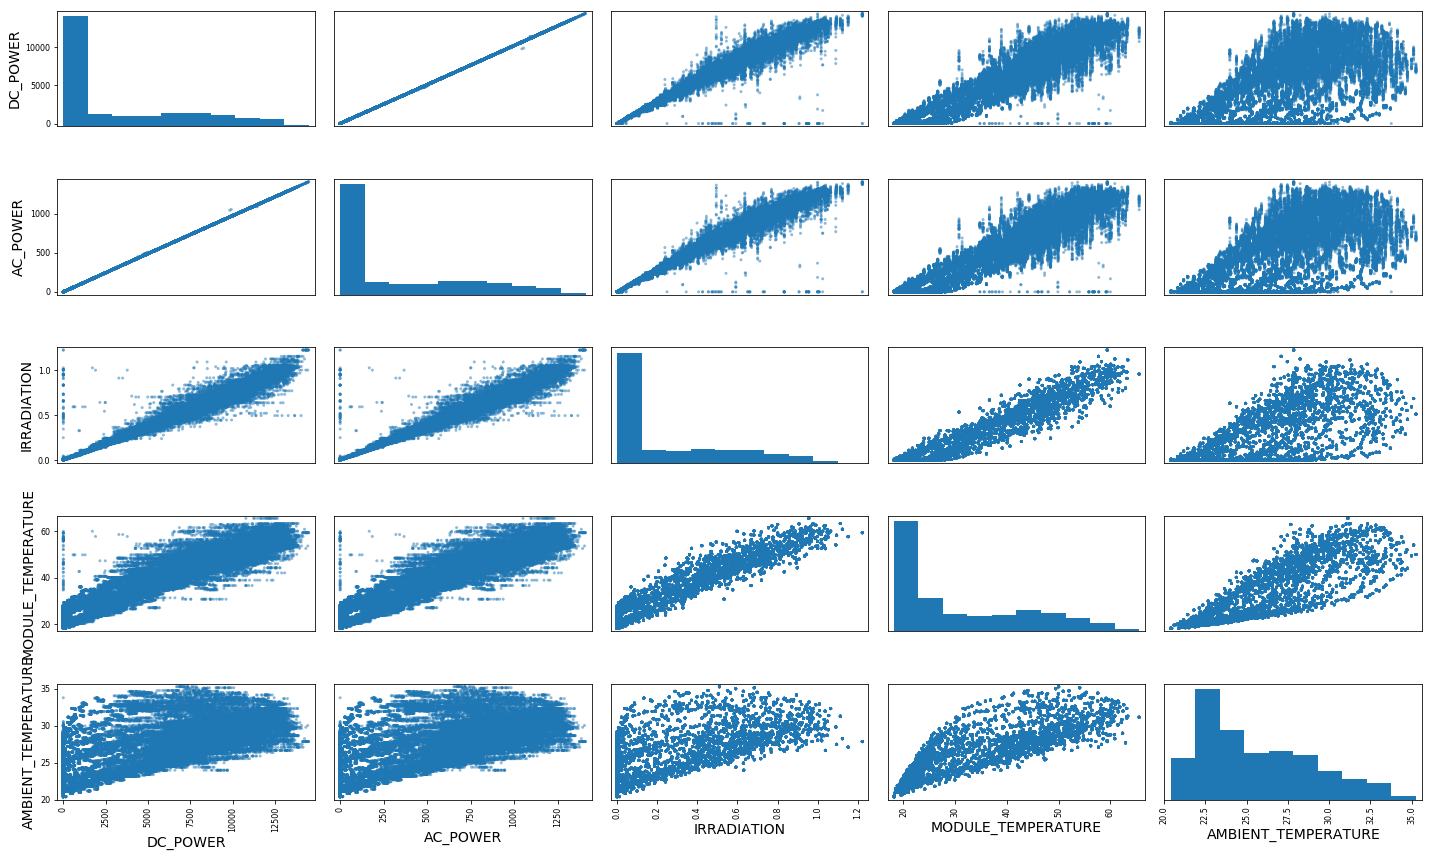

In [51]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Data_analysis"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


attributes = ["DC_POWER", "AC_POWER", "IRRADIATION",
              "MODULE_TEMPERATURE","AMBIENT_TEMPERATURE"]
scatter_matrix(df_plant_weather1[attributes], figsize=(20, 12))
save_fig("scatter_matrix_plot")

Analysis of DC power generated from each Source Keys.
1. The DC power generation plot shows multiple occasion where power generated was zero during daytime.
2. Distribution plot of solar irradiation exhibits that the solar radiation never dropped to a lower value at day time. 
3. Analysis shows some inverters received no DC power even through there was enough sunlight
4. It could be concluded that the DC power generated and solar irradiation has a linear relationship.

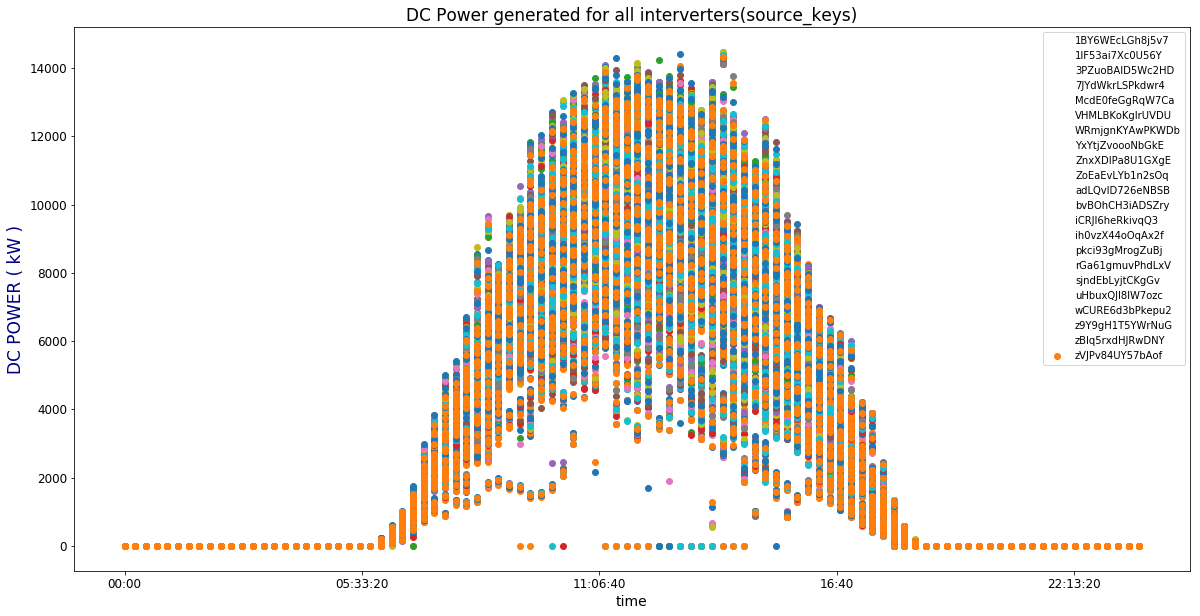

In [52]:
#DC power generated from each source keys
sources=df_plant_weather1.copy()
sources['time']=sources['DATE_TIME'].dt.time
sources.set_index('time').groupby('SOURCE_KEY')['DC_POWER'].plot(style='o',legend=True,figsize=(20,10))
plt.title('DC Power generated for all interverters(source_keys)',size=17)
plt.ylabel('DC POWER ( kW )',color='navy',fontsize=17)
plt.show()

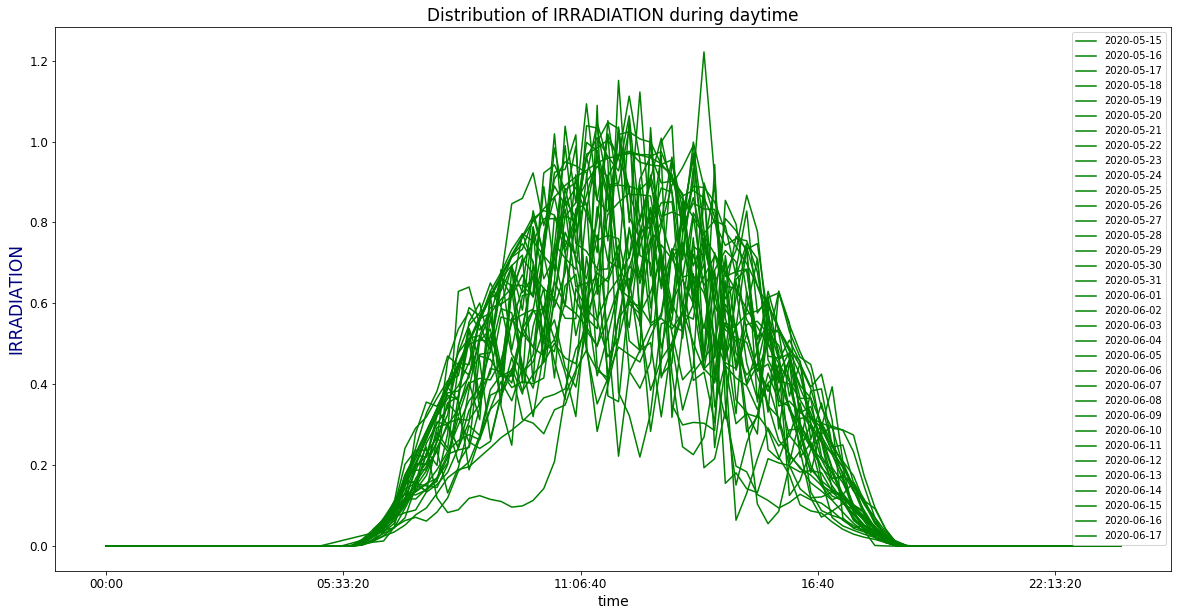

In [53]:
#Solar IRRADIATION generated for days
sources=df_plant_weather1.copy()
sources['time']=sources['DATE_TIME'].dt.time
sources['date']=sources['DATE_TIME'].dt.date
sources.set_index('time').groupby('date')['IRRADIATION'].plot(style='g',legend=True,figsize=(20,10))
plt.title('Distribution of IRRADIATION during daytime',size=17)
plt.ylabel('IRRADIATION',color='navy',fontsize=17)
plt.show()

In [54]:
plt.figure(figsize=(10,5))
fig_irr = sns.scatterplot(data=df_plant_weather1, x="IRRADIATION", y="DC_POWER", hue="SOURCE_KEY", palette="tab20")
plt.show()

ValueError: tab20 is not a valid palette name

In [ ]:

# Function to check if time is during daytime operation

def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

# set normal daytime operation range
start=dt.time(6,30,0) # sunrise
end=dt.time(17,30,0) # sunset

df_plant_weather1["POWER_STATUS"] = 0
for index in df_plant1.index:
  if time_in_range(start, end, df_plant_weather1["DATE_TIME"][index])  and df_plant_weather1["DC_POWER"][index] == 0:
    df_plant_weather1["POWER_STATUS"][index] = "F"
  else:
    df_plant_weather1["POWER_STATUS"][index] = "Ok"

       

TypeError: Cannot compare type 'Timestamp' with type 'time'

In [ ]:
# Model
reg = LinearRegression()

# choose training data
train_dates = ["2020-05-16", "2020-05-17","2020-05-18" ,"2020-05-19", "2020-05-20", "2020-05-21"]
df_train = df_plant_weather1[df_plant_weather1["DATE_TIME"].isin(train_dates)]

#fit & predict
reg.fit(df_train[["IRRADIATION"]], df_train.DC_POWER)
prediction = reg.predict(df_plant_weather1[["IRRADIATION"]])

prediction

NameError: name 'LinearRegression' is not defined

In [ ]:
X = df_plant_weather1[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']] # Features
Y = df_plant_weather1['DC_POWER'] # Target

In [ ]:
df_plant_weather1.sample(10)

def make_sample(df,min):
    x = df.copy()
    x.drop("SOURCE_KEY", axis = 1)
    x.set_index("DATE_TIME", inplace = True)
    return x.resample(str(min) + " min").mean()

df30 = make_sample(df_plant_weather1, 30)
df60 = make_sample(df_plant_weather1, 60)
df2h = make_sample(df_plant_weather1, 120)
df4h = make_sample(df_plant_weather1, 240)


In [ ]:
X1=df_plant_weather1[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']] # Features 
y1=df_plant_weather1['DC_POWER'] # independent var / predictor

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=1)

print("Shape of each Dataset : ")
print("X Train Shape = ",X1_train.shape)
print("Y Train Shape = ",y1_train.shape)
print("X Test Shape  = ",X1_test.shape)
print("Y Test Shape  = ",y1_test.shape)

Shape of each Dataset : 
X Train Shape =  (55019, 2)
Y Train Shape =  (55019,)
X Test Shape  =  (13755, 2)
Y Test Shape  =  (13755,)


In [ ]:
lm = LinearRegressionCV(5)

In [ ]:
 #fit on training data
lm.fit(X1_train, y1_train)
lm.intercept_, lm.coef_

(920.6248402171536, array([-413.9842869 ,  409.91249727]))

In [ ]:
print ('Plant 1 linear regression cofficients are:', X.columns, lm.coef_ )
print('Plant 1 intercept', lm.intercept_)

Plant 1 linear regression cofficients are: Index(['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE'], dtype='object') [-413.9842869   409.91249727]
Plant 1 intercept 920.6248402171536


In [ ]:
#Prediction from model
Prediction_plant1 = lm.predict (X1_test)
Prediction_plant1
Y1_pred_train = lm.predict(X1_train)
Y1_pred_test = lm.predict(X1_test)

print ('Prediction Train dataset', Y1_pred_train)
print ('Prediction Train dataset', Y1_pred_test)

PRediction Train dataset [3264.82777332 -114.64196071 -120.98242659 ... -256.72732164   21.82473248
 6310.7902236 ]
PRediction Train dataset [11008.24592709   396.78766468   386.04596438 ...  -146.74862025
  -133.70859379  3497.43729934]


Text(0, 0.5, 'Actual Output')

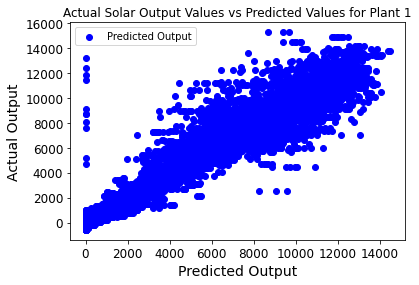

In [ ]:

# This also includes faulty days dataset
plt.scatter(Y_test, Y1_pred_test,color="b", label="Predicted Output")
#plt.scatter(Y_test, DC_POWER, label="Measured Output")
#plt.plot(X, Y, "b.")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

In [ ]:
from sklearn import metrics

# PLANT 1
MAE1 = metrics.mean_absolute_error(y1_test, Y1_pred_test)
MSE1 = metrics.mean_squared_error(y1_test, Y1_pred_test)
RMSE1 = np.sqrt(metrics.mean_squared_error(y1_test, Y1_pred_test))
print('Metrics for Plant 1 Linear Model')
print('MAE: ', MAE1)
print('MSE: ',MSE1)
print('RMSE: ', RMSE1)
print()

Metrics for Plant 1 Linear Model
MAE:  259.8284056028529
MSE:  305558.14081381034
RMSE:  552.7731368416978



In [ ]:
print("Model Evaluation for Linear Regression Model 1 using RMSE")
print("")
RMSE_train_1 = np.sqrt( metrics.mean_squared_error(y1_train, Y1_pred_train))
RMSE_test_1 = np.sqrt(metrics.mean_squared_error(y1_test, Y1_pred_test))
print('RMSE for training set = {}'.format(round(RMSE_train_1,2)))
print('RMSE for test set = {}'.format(round(RMSE_test_1,2)))

Model Evaluation for Linear Regression Model 1 using RMSE

RMSE for training set = 591.72
RMSE for test set = 552.77


In [ ]:
## acuracy score
train_score_1 = lm.score(X1_train, y1_train)
test_score_1 = lm.score(X1_test, y1_test)

print("Model 1 accuracy score: ")
print("")
print("Train Score = ",round(train_score_1*100,0),"%")
print("Test Score  = ",round(test_score_1*100,0), "%")

Model 1 accuracy score: 

Train Score =  94.0 %
Test Score  =  94.0 %


Model 2: Random Forest

In [ ]:
## Select columns that will be used to create train and test dataset
model_2 = df_plant_weather1
model_2.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME,DATE
0,2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
1,2020-05-15,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
2,2020-05-15,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
3,2020-05-15,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0,00:00:00,2020-05-15
4,2020-05-15,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0,00:00:00,2020-05-15


In [ ]:
## create list using feature columns
#model_2_features = model_2['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

# use above list to select subset of original dataframe
#X2 = model_2[model_2_features]
#y3 = model_2["DC_POWER"] # dependent variable / output

X2 = model_2[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']] # Features
y2 = model_2['DC_POWER'] # Target

X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=0.20, random_state=1) 

print("Shape of each New Dataset : ")
print("X Train Shape = ",X2_train.shape)
print("Y Train Shape = ",y2_train.shape)
print("X Test Shape  = ",X2_test.shape)
print("Y Test Shape  = ",y2_test.shape)

Shape of each New Dataset : 
X Train Shape =  (55019, 3)
Y Train Shape =  (55019,)
X Test Shape  =  (13755, 3)
Y Test Shape  =  (13755,)


In [ ]:

RF = RandomForestRegressor()
RF.fit(X2_train, y2_train)

RandomForestRegressor()

In [ ]:
y2_pred_train = RF.predict(X2_train)
y2_pred_test = RF.predict(X2_test)

In [ ]:
print("Model Evaluation for Random Forest Model 2 using RMSE")

RMSE_train_2 = np.sqrt( metrics.mean_squared_error(y2_train, y2_pred_train))
RMSE_test_2 = np.sqrt(metrics.mean_squared_error(y2_test, y2_pred_test))
MSE_train_2 = ( metrics.mean_squared_error(y2_train, y2_pred_train))
print('RMSE for training set is {}'.format(round(RMSE_train_2,2)))
print('RMSE for test set is {}'.format(round(RMSE_test_2,2)))
print('MSE for train set is {}'.format(round(MSE_train_2,2)))

Model Evaluation for Random Forest Model 2 using RMSE
RMSE for training set is 465.42
RMSE for test set is 461.81
MSE for train set is 216619.87


In [ ]:
## acuracy scorefor Model 2
## acuracy score
train_score_2 = RF.score(X2_train, y2_train)
test_score_2 = RF.score(X2_test, y2_test)

print("Model 2 accuracy score: ")
print("")
print("Train Score = ",round(train_score_2*100,0),"%")
print("Test Score  = ",round(test_score_2*100,0), "%")

Model 2 accuracy score: 

Train Score =  99.0 %
Test Score  =  99.0 %


Text(0, 0.5, 'Actual Output')

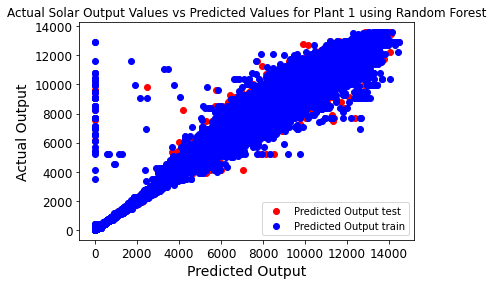

In [ ]:
# This also includes faulty days dataset
plt.scatter(y2_test, y2_pred_test,color="r", label="Predicted Output test")
plt.scatter(y2_train, y2_pred_train,color="b", label="Predicted Output train")
#plt.scatter(Y_test, DC_POWER, label="Measured Output")
#plt.plot(X, Y, "b.")
plt.legend()
plt.title('Actual Solar Output Values vs Predicted Values for Plant 1 using Random Forest')
plt.xlabel('Predicted Output')
plt.ylabel('Actual Output')

In [ ]:
#Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X2_train)
X_test = sc.transform(X2_test)

In [ ]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X2_train, y2_train)
y3_pred = regressor.predict(X2_test)

In [ ]:

conv_2020 = df_plant_weather1
conv_2020.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME,DATE,POWER_STATUS
0,2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0,00:00:00,2020-05-15,0
1,2020-05-15,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0,00:00:00,2020-05-15,0
2,2020-05-15,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0,00:00:00,2020-05-15,0
3,2020-05-15,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0,00:00:00,2020-05-15,0
4,2020-05-15,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0,00:00:00,2020-05-15,0


In [ ]:
X = conv_2020['DATE_TIME']
y = conv_2020['DC_POWER']
slope, intercept, r, p, std_err = stats.linregress(X, y)

def modelPrediction(x):
  return slope * x + intercept

label = 'Model Prediction for conventional avocado in 2020 is = '

model = list(map(modelPrediction, X)) # scipy

x_pred = 2020
y_pred = modelPrediction(x_pred)
print(label)

ap_conv_2020 = round(y_pred, 2)
print('$ {}'.format(ap_conv_2020))
print("")

plt.scatter(X, y) # Scatter Plot
plt.plot(X, model, color='red')
plt.ylim(ymin=0) # starts at zero
plt.legend(['Model Prediction', 'Conventional Avocado Prices (2015-2019)'])
plt.show()

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')